#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **6.3 Actividad Semanas 6 y 7: Modelado de tópicos - LSI/LDA**


###**Entregado por:**

* Maricel Parra Osorio | A01793932
* Ivan Pedraza | A01795371
* Jorge Pedroza | A01319553
* Alberto Patraca Sotomayor | A01793469
* Ivan Pedrero | A01366501

##En la actividad de esta semana se trabajará en equipos en el tema de modelado de temas (topic modeling).

**Descargar el archivo noticiasTopicModeling.txt**

- El archivo de texto es una lista en el siguiente formato: [{“titular”:”Encabezado“, “texto”:”Cuerpo”}, … , {“titular”:”Encabezado”,”texto”:”Cuerpo”}] donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia.
- En particular en esta actividad se trabajará solamente con los cuerpos de las noticias, sin incluir los encabezados.

- Cargar dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [4]:
!python -m spacy download es_core_news_sm  # Se descarga el modelo en español

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 23.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
import re
import nltk
import spacy
import pandas as pd
import ipywidgets as widgets
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Descargar y cargar el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

# Carga de file de texto y creación del DataFrame
with open('/content/drive/MyDrive/Training/TEC/MNA/NLP/Actividades/6.3 Modelado de tópicos LSI LDA/noticiasTopicModeling.txt', 'r', encoding='utf-8') as file:
    noticias = eval(file.read())  # Cargar el contenido del archivo como una lista de diccionarios

df = pd.DataFrame(noticias)
df.head()

,titular,texto
0,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu..."
1,Mensajes xenófobos de Vox y la cancelación de ...,El clima de crispación social en Ceuta ha lleg...
2,El Gobierno alega el estado de alarma para no ...,El Gobierno ha alegado la suspensión de plazos...
3,La fiscala,"Puedes mandar tu pregunta, sugerencia o queja ..."
4,La CorteIDH pide a Panamá informe sobre migran...,Panamá debe entregar esta semana a la Corte In...


**Se hace la limpieza del texto**

Se realiza  un proceso de limpieza y se aplica el preprocesamiento mediante la función stopwords. El objetivo es identificar los tokens (palabras) que describan mejor la distribución de cada tema.

In [7]:
df['texto'] = df['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Eliminar signos de puntuación

# Realizar el preprocesamiento de texto
stop_words = set(stopwords.words('spanish'))

preprocessed_text = []
preprocessed_tokens = []
for text in tqdm(df['texto']):
    text = text.lower()
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    preprocessed_text.append(' '.join(filtered_tokens))
    preprocessed_tokens.append(filtered_tokens)

df['noticia'] = preprocessed_text
df.head()

  0%|          | 0/5658 [00:00<?, ?it/s]

,titular,texto,noticia
0,Vox se sube a la ola de la extrema derecha eur...,España ha dejado de ser católica decía Manuel ...,españa haber dejar ser católico decir manuel a...
1,Mensajes xenófobos de Vox y la cancelación de ...,El clima de crispación social en Ceuta ha lleg...,clima crispación social ceuta haber llegar pun...
2,El Gobierno alega el estado de alarma para no ...,El Gobierno ha alegado la suspensión de plazos...,gobierno haber alegar suspensión plazo derivad...
3,La fiscala,Puedes mandar tu pregunta sugerencia o queja a...,poder mandar pregunta sugerencia queja través ...
4,La CorteIDH pide a Panamá informe sobre migran...,Panamá debe entregar esta semana a la Corte In...,panamá deber entregar semana corte interameric...


### Nota: Esta es una técnica no supervisada, por lo que no se requiere hacer una partición de los datos.

#Parte 1: Indexación semántica latente (LSI):

3. Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens.

In [9]:
# Calcular la matriz Tf-idf
vectorizer = TfidfVectorizer(min_df=10)
tfidf_matrix = vectorizer.fit_transform(df['noticia'])

# Obtener los nombres de las características y eliminar las columnas que no son palabras en español
feature_names = vectorizer.get_feature_names_out()
keep_columns = []

for col in tqdm(range(tfidf_matrix.shape[1])):
    token = feature_names[col]
    doc = nlp(token)
    if doc.has_vector:
        keep_columns.append(col)

tfidf_matrix = tfidf_matrix[:, keep_columns]
feature_names = [feature_names[col] for col in keep_columns]

# Crear el DataFrame con los valores de Tf-idf
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
display(df_tfidf.head())

  0%|          | 0/12375 [00:00<?, ?it/s]

,abad,abadía,abajo,abanderar,abandonado,abandonar,abandono,abanico,abaratar,abarcar,...,órdago,órden,órgano,óscar,últimamente,último,única,únicamente,único,útil
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017007,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.019959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.027002,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.013087,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?

xxxxxxxxxxxxxxxxxxxxxx

Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

In [10]:
# Se define el objeto que aplicará SVD truncada con r valores singulares:

r = 10    # Máxima cantidad de valores singulares a considerar --> tópicos a generar:

lsi_obj = TruncatedSVD(n_components = r,
                       n_iter=100,  # número de iteraciones ... recordemos que es un método iterativo.
                       random_state=42)

tfidf_lsi = lsi_obj.fit_transform(tfidf_matrix)    # ndarray: se ajusta y aplica la SVD truncada.


Sigma = lsi_obj.singular_values_     # ndarray_(r,)

V_T = lsi_obj.components_.T         # ndarray_(n_terms X r)
                                    # Las r columnas son los r temas/topics generados
                                    # Se ordenan los n_terms/words de mayor a menor para
                                    # obtener las keywords principales de cada tópico.
sigmas = lsi_obj.singular_values_
sigmas

array([21.1792883 ,  8.26317442,  7.43751975,  6.28179021,  6.2009425 ,
        6.12125831,  5.92276759,  5.39411513,  5.31637977,  5.22691724])

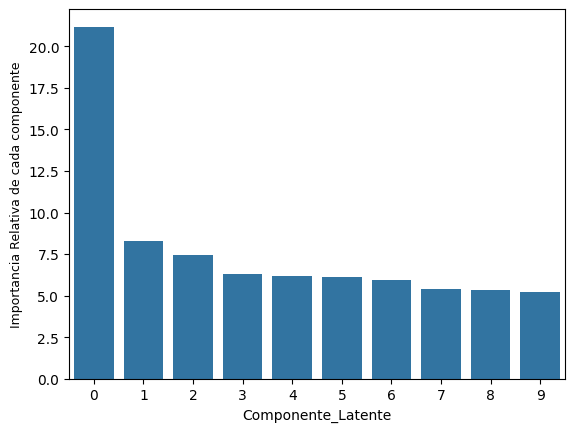

In [11]:
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma )
chart.set_xlabel('Componente_Latente', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada componente', fontdict={'size': 9})
plt.show()

Obtener la matriz tokens-temas (term-topic) a partir de la matriz 𝑉􀯍 de la descomposición SVD. Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [12]:
lsi_term_topic = V_T

# rescatemos los nombres de los términos/tokens:

term_names = feature_names

print(term_names[:19])

['abad', 'abadía', 'abajo', 'abanderar', 'abandonado', 'abandonar', 'abandono', 'abanico', 'abaratar', 'abarcar', 'abarrotado', 'abascal', 'abastecer', 'abastecimiento', 'abasto', 'abatido', 'abatir', 'abc', 'abdicación']


In [13]:
# Y generamos un DataFrame con la matriz term-topic:

term_topic_matrix = pd.DataFrame(data=lsi_term_topic,
                                 index = term_names,
                                 columns = [f'Concepto_Latente_{r}' for r in range(0,V_T.shape[1])]
                                )

print(term_topic_matrix.shape)   #  words X topics
term_topic_matrix.head()

(12375, 10)


,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
abad,0.000814,-0.000970,-0.000576,0.001257,0.000370,0.000113,-0.000526,0.000016,0.000627,-0.000386
abadía,0.000513,-0.001006,-0.000513,0.000280,-0.000060,0.000146,0.000653,-0.000137,-0.000373,-0.000624
abajo,0.002840,-0.001833,-0.005738,0.000790,-0.000399,0.001051,-0.001761,0.001603,-0.000028,0.001850
abanderar,0.000567,-0.001264,0.000689,-0.001096,-0.000315,0.000765,-0.000080,-0.000642,0.000276,-0.000528
abandonado,0.002193,-0.000701,-0.003722,0.000894,-0.001371,-0.000032,-0.000230,0.000264,0.001108,-0.000340


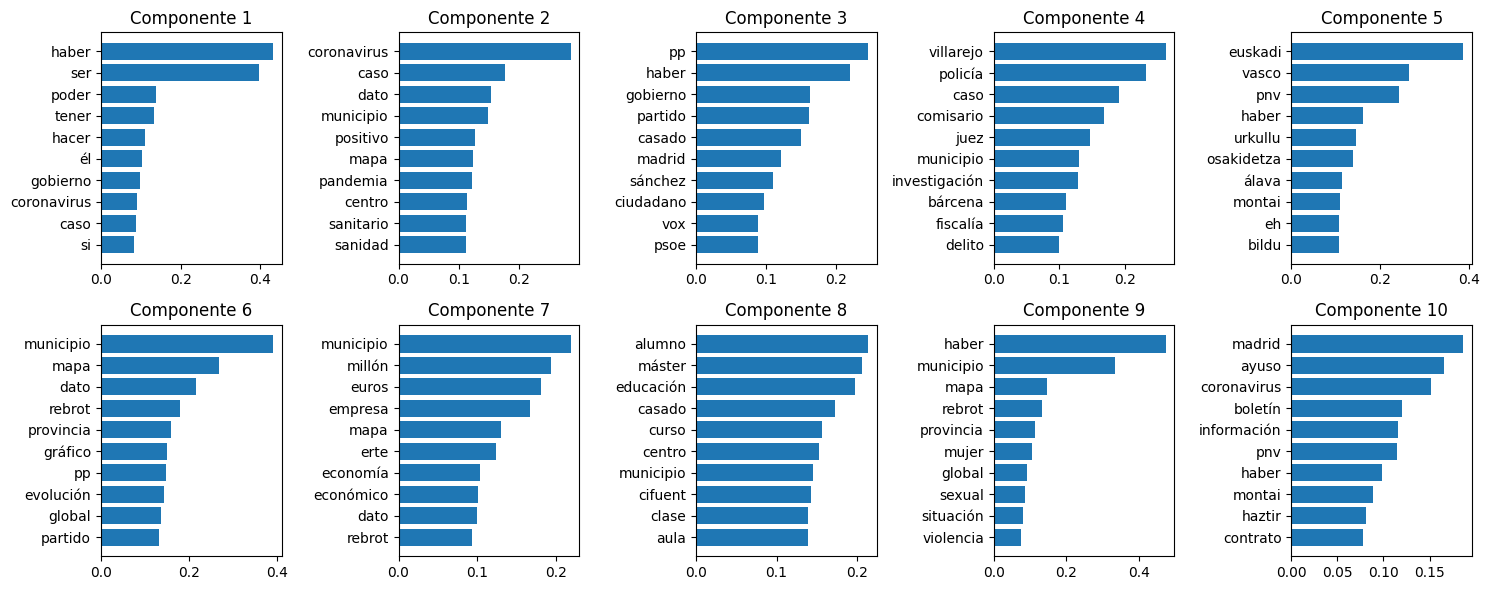

In [14]:
# Crear una figura y un arreglo de ejes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Aplanar el arreglo de ejes para iterar sobre él
axes = axes.flatten()

# Iterar sobre las componentes
for i in range(10):
    # Seleccionar los 10 términos con mayor peso en la componente i usando iloc
    top_terms = term_topic_matrix.iloc[:, i].sort_values(ascending=True).tail(10) #invertido para plotear de forma descendente segun su valor.

    # Obtener los nombres y los pesos de los términos
    names = top_terms.index
    values = top_terms.values

    # Hacer un gráfico de barras horizontal con los nombres y los pesos de los términos en el eje i
    axes[i].barh(names, values)

    # Añadir un título al eje i con el número de la componente
    axes[i].set_title(f'Componente {i+1}')

# Ajustar el espacio entre los ejes
plt.tight_layout()

# Mostrar la figura
plt.show()

Con base a la cantidad de conceptos latentes que determinaste en el ejercicio anterior, obtener cada uno de sus gráficos con sus 10 términos/tokens más importantes. ¿Cómo describirías cada uno de dichos conceptos latentes? ¿Se identifican claramente las temáticas de cada uno de ellos?

XXXXXXXXXXXXXXXXXXXXXXXXXXX

#Parte 2: Asignación de Dirichlet Latente (LDA):

Utiliza la librería Gensim para implementar ahora la técnica de LDA. Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable:
https://radimrehurek.com/gensim/models/ldamodel.html
https://radimrehurek.com/gensim/models/ldamulticore.html

In [15]:
from gensim.models import LsiModel, CoherenceModel
from gensim.corpora import Dictionary

common_dictionary = Dictionary(preprocessed_tokens)
common_dictionary.filter_extremes(no_below=10, no_above=0.5)

common_corpus = [common_dictionary.doc2bow(text) for text in preprocessed_tokens]#Parte 2: Asignación de Dirichlet Latente (LDA):

In [16]:
# Crear una lista vacía para guardar los modelos y los valores de coherencia
models = []
coherences = []

# Iterar sobre el rango de 2 a 10 temas
for num_topics in tqdm(range(2, 11)):
    # Crear un objeto LsiModel con el corpus, el diccionario y el número de temas
    lsi_model = LsiModel(corpus=common_corpus, id2word=common_dictionary, num_topics=num_topics)

    # Crear un objeto CoherenceModel con el modelo LSI, el corpus, el diccionario y el tipo de coherencia
    coherence_model = CoherenceModel(model=lsi_model, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v', texts=preprocessed_tokens)

    # Obtener el valor de coherencia del modelo
    coherence = coherence_model.get_coherence()

    # Añadir el modelo y el valor de coherencia a la lista
    models.append(lsi_model)
    coherences.append(coherence)

  0%|          | 0/9 [00:00<?, ?it/s]

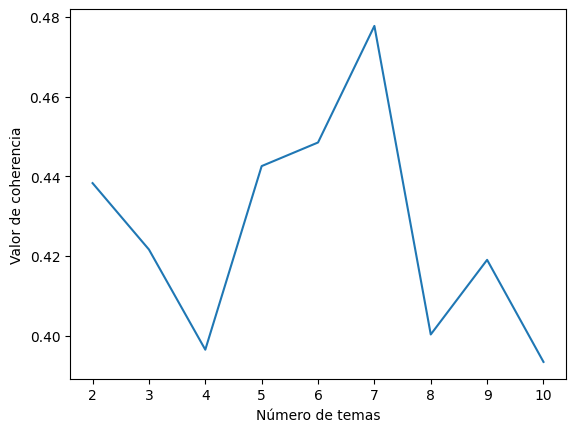

In [17]:
fig, ax = plt.subplots()

ax.plot(range(2, 11), coherences)

ax.set_xlabel('Número de temas')
ax.set_ylabel('Valor de coherencia')

plt.show()

In [ ]:
from gensim.models import LdaMulticore, CoherenceModel

# Crear una lista vacía para guardar los modelos y los valores de coherencia
models = []
coherences = []

# Iterar sobre el rango de 2 a 10 temas
for num_topics in tqdm(range(2, 11)):
    # Crear un objeto LdaMulticore con el corpus, el diccionario y el número de temas
    lda_model = LdaMulticore(corpus=common_corpus, id2word=common_dictionary, num_topics=num_topics, workers=20)

    # Crear un objeto CoherenceModel con el modelo LDA, el corpus, el diccionario, el tipo de coherencia y los textos
    coherence_model = CoherenceModel(model=lda_model, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v', texts=preprocessed_tokens)

    # Obtener el valor de coherencia del modelo
    coherence = coherence_model.get_coherence()

    # Añadir el modelo y el valor de coherencia a la lista
    models.append(lda_model)
    coherences.append(coherence)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots()

ax.plot(range(2, 11), coherences)

ax.set_xlabel('Número de temas')
ax.set_ylabel('Valor de coherencia')

plt.show()

Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias? ¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a considerar?

XXXXXXXXXXXXXXXXXXXXXXXXX

#Conclusiones finales

- XXXXXXX